In [ ]:
#THIS SCRIPT WILL MAKE INTEGRATED SEURAT OBJECT WITH STANDARD WORKFLOW, WITHOUT PROTOPLAST INDUCED 
#GENES, OR MITO/CP GENES IN THE VARIABLE FEATURE LIST
#THIS INTEGRATES WT AND MUTANT

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
if (!requireNamespace("here", quietly = TRUE))
    install.packages("here")
if (!requireNamespace("ggplot2", quietly = TRUE))
    install.packages("ggplot2")
if (!requireNamespace("ggpointdensity", quietly = TRUE))
    install.packages("ggpointdensity")
if (!requireNamespace("DropletUtils", quietly = TRUE)) 
    BiocManager::install("DropletUtils")
if (!requireNamespace("BUSpaRse", quietly = TRUE)) 
    BiocManager::install("BUSpaRse")
if (!requireNamespace("scico", quietly = TRUE))
    install.packages("scico")
if (!requireNamespace("reticulate", quietly = TRUE))
    install.packages("reticulate")
if (!requireNamespace("future", quietly = TRUE))
    install.packages("future")
if (!requireNamespace("DoubletFinder", quietly = TRUE))
    remotes::install_github('chris-mcginnis-ucsf/DoubletFinder')
if (!requireNamespace("tidyverse", quietly = TRUE))
    install.packages("tidyverse")
#devtools::install_github(repo = 'satijalab/seurat', ref = 'develop')
# if (!requireNamespace("COPILOT", quietly = TRUE))
#     devtools::install_github('Hsu-Che-Wei/COPILOT')

In [ ]:
library(BUSpaRse)
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scico)
library(scales)
library(DropletUtils)
library(reticulate)
library(repr)
library(DoubletFinder)
library(future)
options(future.globals.maxSize = 100000 * 1024^2)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 4,]$genes)

In [10]:
wt_1_seu = readRDS(file = "../data/seurat1/sc_26_seu_1.rds")
wt_2_seu = readRDS(file = "../data/seurat1/sc_67_seu_1.rds")
mut_1_seu = readRDS(file = "../data/seurat1/sc_27_seu_1.rds")
mut_2_seu = readRDS(file = "../data/seurat1/sc_68_seu_1.rds")

In [ ]:
all_intd_std = std_integrate(wt_1_seu, wt_2_seu, mut_1_seu, mut_2_seu, filename = "std_intd_all_4_minus_protos_mt_cp", nfeatures = 3000)

In [40]:
all_intd_std = readRDS("../data/intd_seu_objects/std_intd_all_4_minus_protos_mt_cp.rds")

Warning message in gzfile(file, "rb"):
"cannot open compressed file '../data/intd_seu_objects/std_intd_wt_4_minus_protos_mt_cp.rds', probable reason 'No such file or directory'"


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [ ]:
DefaultAssay(all_intd_std) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
all_intd_std <- ScaleData(all_intd_std, verbose = FALSE)
all_intd_std <- RunPCA(all_intd_std, npcs = 30, verbose = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

all_intd_std <- FindNeighbors(all_intd_std, dims = 1:10)
all_intd_std <- FindClusters(all_intd_std, resolution = 0.5)
all_intd_std <- RunUMAP(all_intd_std, reduction = "pca", dims = 1:30)

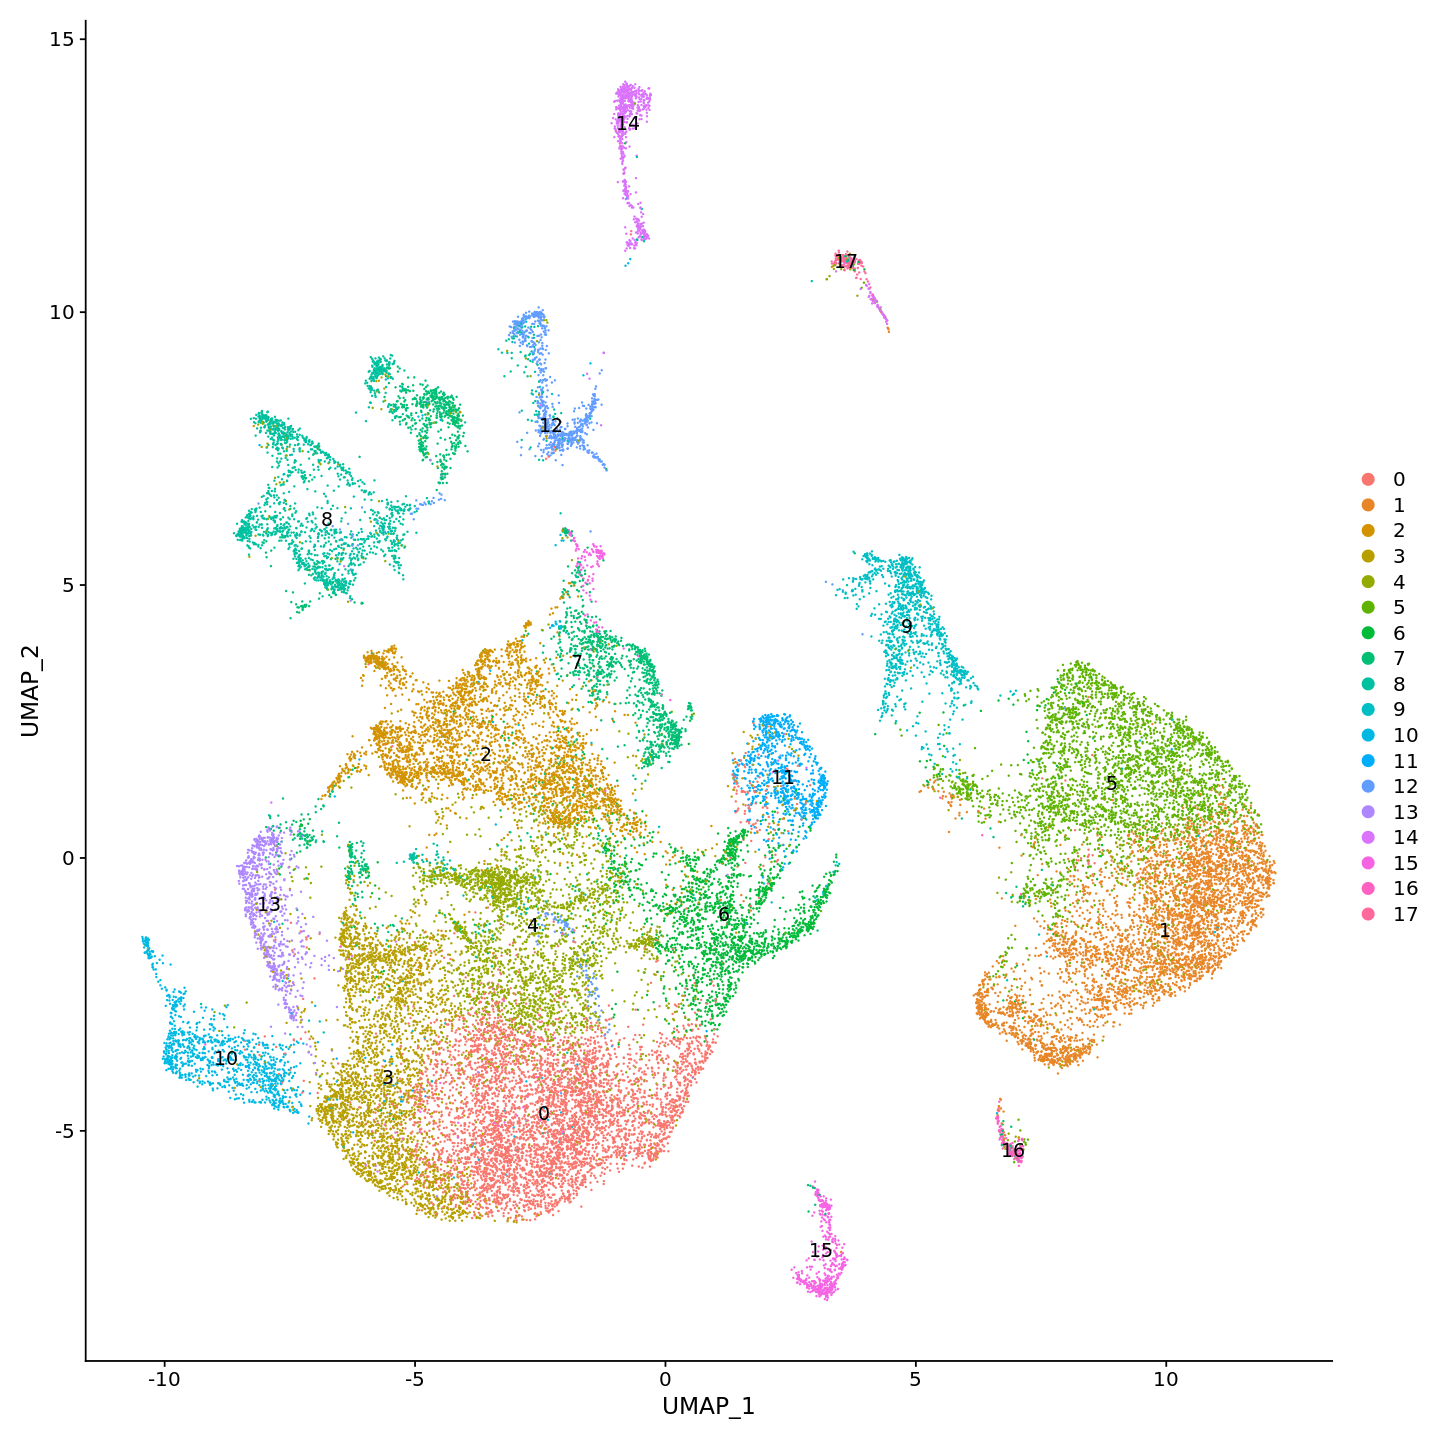

In [4]:
DimPlot(all_intd_std, reduction = "umap", label = TRUE)

In [11]:
all_intd_std@meta.data$orig.ident = c(rep("WT_1",length(colnames(wt_1_seu@assays$RNA))), rep("WT_2",length(colnames(wt_2_seu@assays$RNA))), rep("MUT_1",length(colnames(mut_1_seu@assays$RNA))), rep("MUT_2",length(colnames(mut_2_seu@assays$RNA))))

In [16]:
table(Idents(all_intd_std), all_intd_std$orig.ident)

    
     MUT_1 MUT_2 WT_1 WT_2
  0   1869  1233  967 1144
  1    856  1049 1293 1229
  2   1137   947  732  800
  3   1428   631  751  653
  4   1362   804  676  582
  5    880   644  941  853
  6    785   389  515  387
  7    658   458  458  448
  8    564   504  416  386
  9    338   158  459  239
  10   429   209  214  249
  11   316   154  240  171
  12   364   193  147  176
  13   274   203  161  212
  14   292   162  128  163
  15   255   145  100  132
  16    27    30   51   52
  17    81    26   22   30

In [81]:
wt_1_pb <- rowSums(as.matrix(GetAssayData(subset(all_intd_std, subset = orig.ident == "WT_1"), slot = "counts")[, WhichCells(subset(all_intd_std, subset = orig.ident == "WT_1"), ident = "9")]))
wt_2_pb <- rowSums(as.matrix(GetAssayData(subset(all_intd_std, subset = orig.ident == "WT_2"), slot = "counts")[, WhichCells(subset(all_intd_std, subset = orig.ident == "WT_2"), ident = "9")]))
mut_1_pb <- rowSums(as.matrix(GetAssayData(subset(all_intd_std, subset = orig.ident == "MUT_1"), slot = "counts")[, WhichCells(subset(all_intd_std, subset = orig.ident == "MUT_1"), ident = "9")]))
mut_2_pb <- rowSums(as.matrix(GetAssayData(subset(all_intd_std, subset = orig.ident == "MUT_2"), slot = "counts")[, WhichCells(subset(all_intd_std, subset = orig.ident == "MUT_2"), ident = "9")]))

In [95]:
all_pb = cbind (wt_1_pb, wt_2_pb, mut_1_pb, mut_2_pb)
colnames(all_pb) = c("wt_1_pb", "wt_2_pb", "mut_1_pb", "mut_2_pb")

In [104]:
all_pb_bad_norm[,1] = all_pb[,1]/colSums(all_pb)[1] 
all_pb_bad_norm[,2] = all_pb[,2]/colSums(all_pb)[2] 
all_pb_bad_norm[,3] = all_pb[,3]/colSums(all_pb)[3] 
all_pb_bad_norm[,4] = all_pb[,4]/colSums(all_pb)[4] 
all_pb_bad_norm = all_pb_bad_norm * 1000000

In [116]:
all_pb_bad_norm[c("AT1G61820","AT4G23500","AT1G71380","AT4G30290","AT3G59850","AT4G25810","AT3G60140","AT1G22880","AT3G07970",
"AT4G18340","AT2G41850"),]

all_pb_bad_norm[c("AT4G28490", "AT5G65710","AT1G68765", "AT1G71830","AT2G41850", "AT3G07970", "AT5G03280","AT4G08150", "AT3G45640","AT2G43790"),]

,wt_1_pb,wt_2_pb,mut_1_pb,mut_2_pb
AT1G61820,42.969448,19.571729,35.207323,39.728055
AT4G23500,45.048614,40.709196,9.601997,12.815502
AT1G71380,456.954663,608.811245,22.404660,160.193770
AT4G30290,271.908816,481.203573,127.226463,188.387874
AT3G59850,119.205564,181.364687,18.403828,32.038754
AT4G25810,212.768071,435.536205,224.846768,376.775748
AT3G60140,6.699538,7.045822,48.009986,1.281550
AT1G22880,12.475001,9.394430,4.000832,5.126201
AT3G07970,384.876880,344.723384,25.605326,38.446505
AT4G18340,81.780561,88.203258,26.405492,16.660152


,wt_1_pb,wt_2_pb,mut_1_pb,mut_2_pb
AT4G28490,495.53476,378.386757,295.261414,292.193437
AT5G65710,34.42176,10.960168,5.601165,5.126201
AT1G68765,40.42824,37.577719,28.805992,14.097052
AT1G71830,81.54954,42.796847,24.805159,2.563100
AT2G41850,585.63199,878.118233,177.636948,133.281217
AT3G07970,384.87688,344.723384,25.605326,38.446505
AT5G03280,27.95324,18.005991,15.203162,12.815502
AT4G08150,21.71574,8.611561,8.801831,3.844650
AT3G45640,22.17778,16.179296,62.412982,29.475654
AT2G43790,88.94214,69.414398,72.815146,73.048359


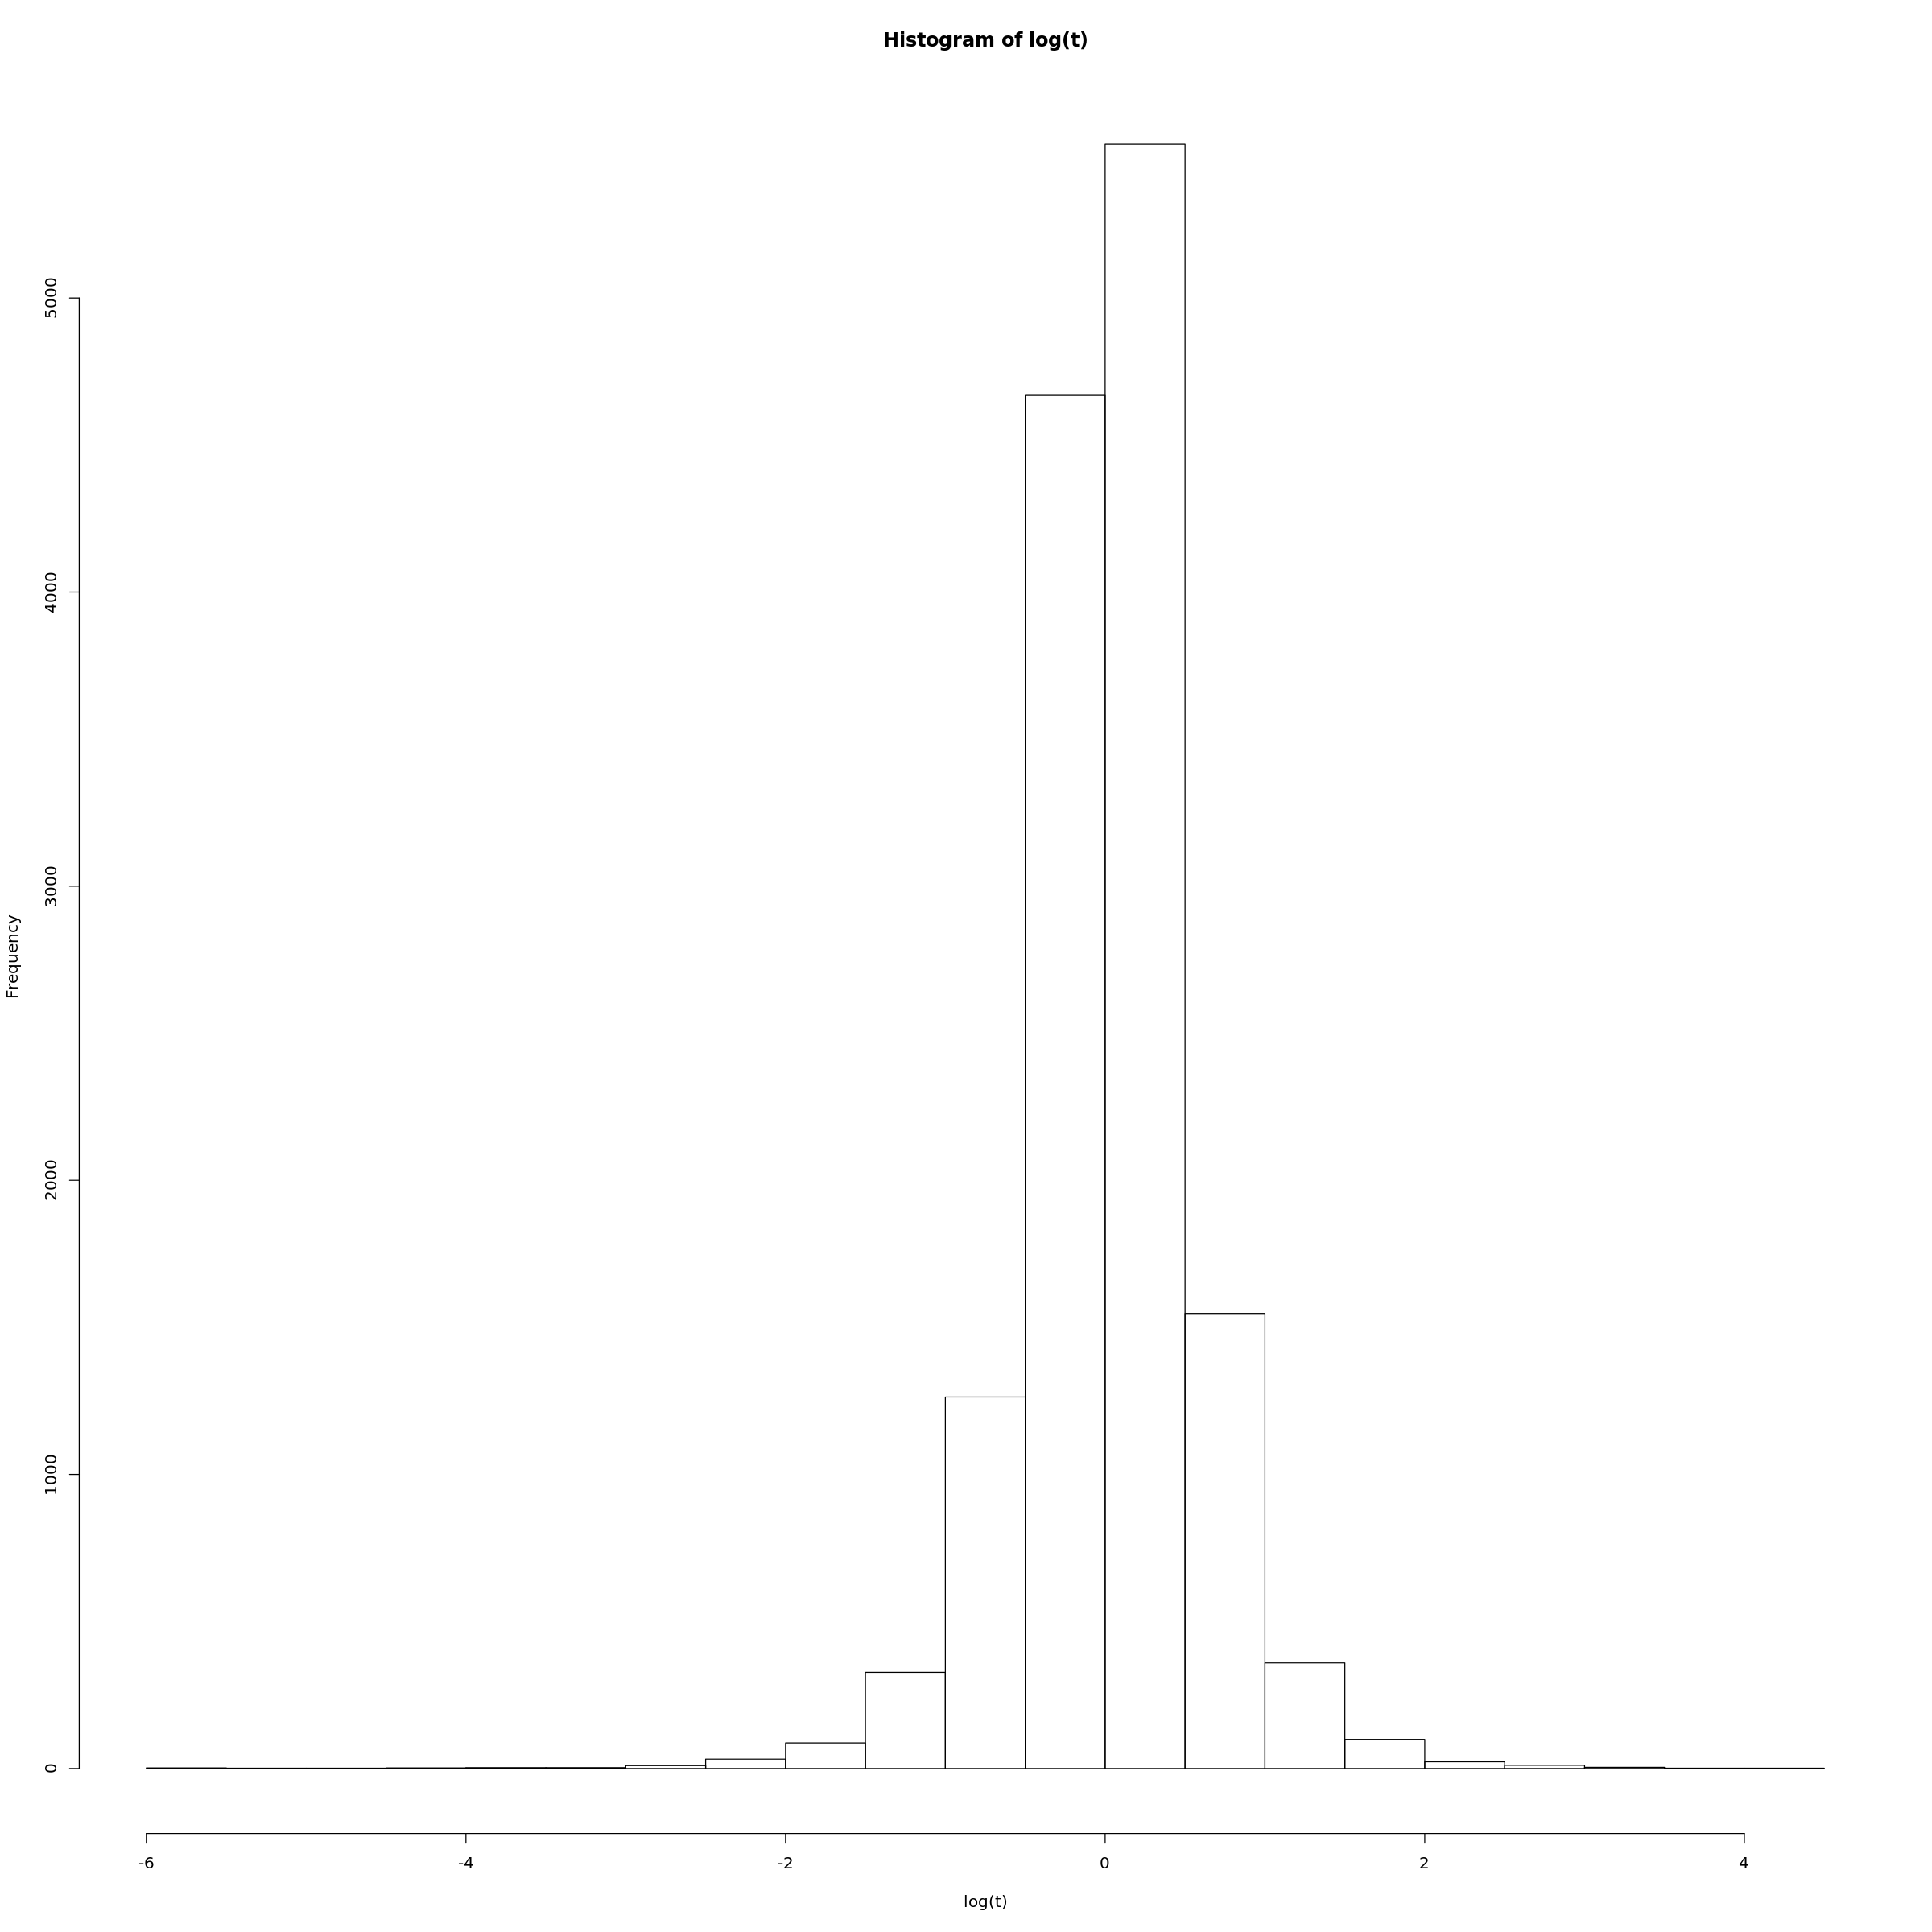

In [125]:
t = rowSums(all_pb_bad_norm[,1:2])/rowSums(all_pb_bad_norm[,3:4])
t = t[rowSums(all_pb_bad_norm)>10]
hist(log(t))

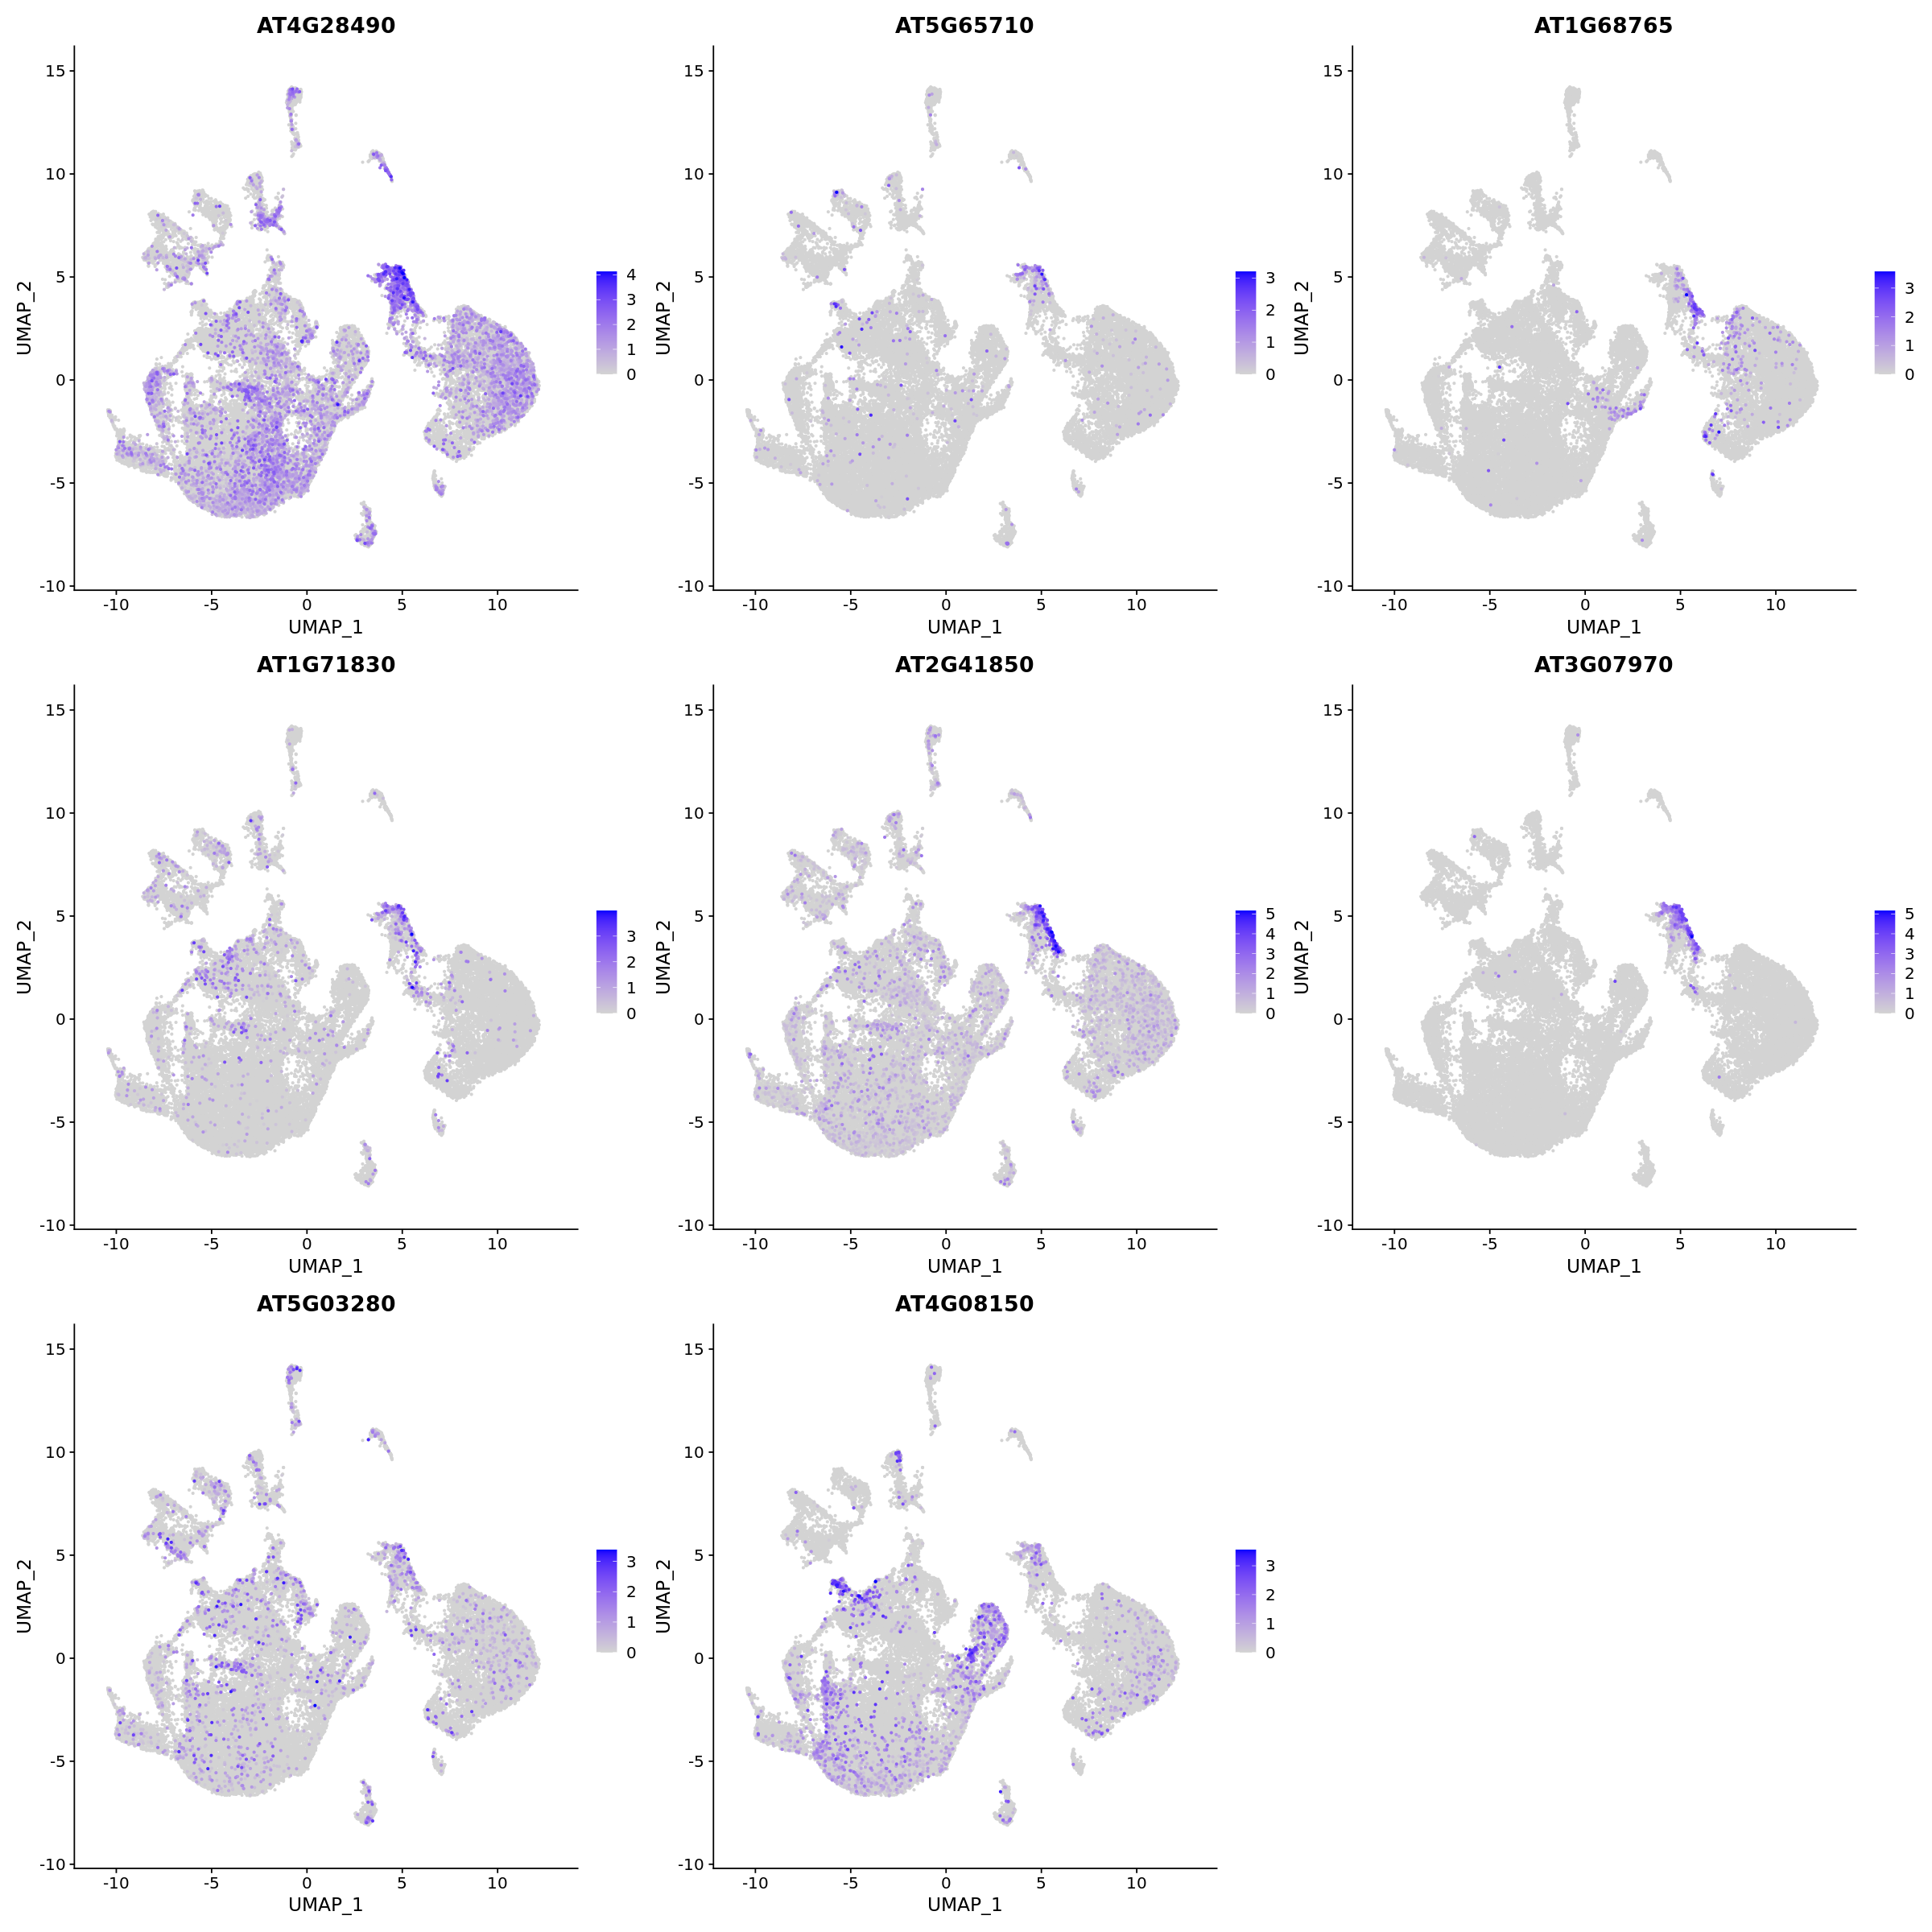

In [115]:
options(repr.plot.width=20, repr.plot.height=20)
all_intd_std@active.assay = "RNA"
FeaturePlot(all_intd_std, features = c("AT4G28490", "AT5G65710","AT1G68765", "AT1G71830","AT2G41850", "AT3G07970", "AT5G03280","AT4G08150"),  pt.size = .5, slot = "data", order = TRUE)

In [109]:
saveRDS(all_intd_std, "../data/intd_seu_objects/std_intd_all_4_minus_protos_mt_cp.rds")

In [27]:
#takes a list of Seurat objects and performs standard integration
std_integrate <- function(..., filename, nfeatures) {
    obj.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    for (i in 1:length(obj.list)) {
        obj.list[[i]] <- NormalizeData(obj.list[[i]], verbose = FALSE)
        obj.list[[i]] <- FindVariableFeatures(obj.list[[i]], selection.method = "vst", nfeatures = nfeatures, verbose = FALSE)
        VariableFeatures(obj.list[[i]]) <-  VariableFeatures(obj.list[[i]])[!c(grepl("ATMG",VariableFeatures(obj.list[[i]])) | grepl("ATCG",VariableFeatures(obj.list[[i]])) | (VariableFeatures(obj.list[[i]]) %in% proto_list))]
    }
    
    rc.anchors <- FindIntegrationAnchors(object.list = obj.list, dims = 1:30)
    rc.integrated <- IntegrateData(anchorset = rc.anchors, dims = 1:30)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
}
